In [1]:
import glob
import json
import os
import numpy as np
import cv2
from skimage import img_as_float
from skimage.draw import line,circle
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.feature import *
from skimage.color import rgb2grey
from scipy import spatial

np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def draw_rectangle(img, x0, y0, x1, y1, color=(0, 0, 0)):
    draw_line(img, x0, y0, x0, y1, color)
    draw_line(img, x0, y0, x1, y0, color)
    draw_line(img, x1, y0, x1, y1, color)
    draw_line(img, x0, y1, x1, y1, color)


def draw_line(img, x0, y0, x1, y1, color=(0, 0, 0)):
    x0 = min(img.shape[1]-1, max(0, x0))
    y0 = min(img.shape[0]-1, max(0, y0))
    x1 = min(img.shape[1]-1, max(0, x1))
    y1 = min(img.shape[0]-1, max(0, y1))
    yy, xx = line(y0,x0,y1,x1)
    img[yy, xx, :] = color



def draw_bbox(img, label):
    img = np.array(img)
    left_hand, right_hand = [], []
    colors = {'L':(1,0,0),'R':(0,1,0)}
    for htype, box in label['bbox'].items():
        hand = np.array(img[box[1]:box[3], box[0]:box[2]])
        if htype == 'L':
            left_hand.append(hand)
        else:
            right_hand.append(hand)
        draw_rectangle(img, box[0], box[1], box[2], box[3], color=colors[htype])
        draw_rectangle(img, box[0] + 1, box[1] + 1, box[2] + 1, box[3] + 1, color=colors[htype])

    return img, left_hand, right_hand



In [3]:
images, labels = [], []
left_hands, right_hands = [], []
img_paths = sorted(glob.glob("data/DeepQ-Vivepaper/data/book/img/img_*.png" )) + sorted(glob.glob("data/DeepQ-Vivepaper/data/air/img/img_*.png" ))
for img_path in img_paths:
    iid = os.path.basename(img_path).replace(".png","").replace("img_","")
    label_path = img_path.replace("img", "label").replace("png", "json")
    img = imread(img_path)
    label = json.load(open(label_path))
    images.append(img)
    labels.append(label)
    
    _, left_hand, right_hand = draw_bbox(img, label)
    left_hands += left_hand
    right_hands += right_hand

In [4]:
def generate_areas(img, shape=(144, 144), stride=20):
    m, n, _ = img.shape
    areas = []
    coors = []
    for i in range(0, m-shape[0], stride):
        for j in range(0, n-shape[1], stride):
            area = img[i:i+shape[0], j:j+shape[1]]
            coor = [j, i, j+shape[1], i+shape[0]]
            areas.append(area)
            coors.append(coor)
    return areas, coors      

def find_hands(img, left_hand, right_hand, shape=(144, 144), stride=20, threshold=0.5, dist=spatial.distance.hamming):
    label = {}
    m, n, _ = img.shape
    areas, coors = generate_areas(img, stride=stride, shape=shape)
    features = [sift_feature(area) for area in areas]
    right_hand_feature = sift_feature(right_hand)
    right_scores = [dist(feature, right_hand_feature) for feature in features]
    ind = np.argsort(-np.array(right_scores))
    right_ind = ind[0]
    for i in range(10):
        print(coors[ind[i]], right_scores[ind[i]])
    if right_scores[right_ind] > threshold:
        label['R'] = coors[right_ind]
        
    left_hand_feature = sift_feature(left_hand)
    left_scores = [dist(feature, left_hand_feature) for feature in features]
    left_ind = np.argsort(left_scores)[-1]
    if left_scores[left_ind] > threshold:
        label['L'] = coors[left_ind]

    return {'bbox': label}

[(39480, [230, 208, 282, 140])]
{'bbox': {'R': [230, 208, 512, 348]}}
{'bbox': {'R': [218, 196, 440, 370], 'L': [214, 315, 302, 453]}}


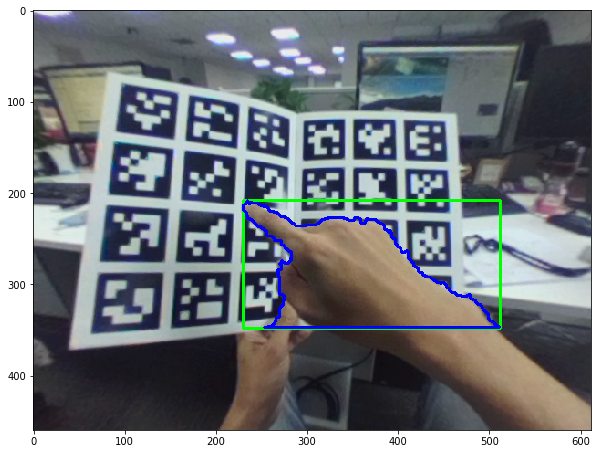

In [150]:
def nice_contour(contour, height=140):
    min_y = min([c[0][1] for c in contour])
    new_contour = [c for c in contour if c[0][1] < min_y + height]
    return np.array(new_contour)

def find_hand_by_color(img, thre_area=4000, color_range=[[0, 87, 131], [255, 137, 170]]):
    img = np.array(img)

    # Constants for finding range of skin color in YCrCb
    min_YCrCb = np.array(color_range[0], np.uint8)
    max_YCrCb = np.array(color_range[1], np.uint8)
    # Find region with skin tone in YCrCb image
    imageYCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    y_cbcr_skinRegion = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)

    #[ 12 117  81]
    #[193 152 123]
    lower_thresh = np.array([0, 0, 0], dtype=np.uint8)
    upper_thresh = np.array([255, 20, 255], dtype=np.uint8)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    lab_skinRegion = cv2.inRange(img_lab, lower_thresh, upper_thresh)

    lower_thresh = np.array([25, 0, 0], dtype=np.uint8)
    upper_thresh = np.array([226, 150, 255], dtype=np.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv_skinRegion = cv2.inRange(img_hsv, lower_thresh, upper_thresh)
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_thresh = np.array([60, 50, 38], dtype=np.uint8)
    upper_thresh = np.array([180, 180, 90], dtype=np.uint8)
    rgb_skinRegion = ~cv2.inRange(img, lower_thresh, upper_thresh)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lower_thresh = np.array([80], dtype=np.uint8)
    upper_thresh = np.array([160], dtype=np.uint8)
    gray_skinRegion = cv2.inRange(img_gray, lower_thresh, upper_thresh)
    
    #fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
    #bg_skinRegion = fgbg.apply(img)
    
    #skinRegion = rgb_skinRegion & gray_skinRegion & 
    skinRegion = y_cbcr_skinRegion #lab_skinRegion  & (~hsv_skinRegion)
    
#     plt.subplot(2,1,1)
#     plt.imshow(y_cbcr_skinRegion)
    
#     plt.subplot(2,3,2)
#     plt.imshow(hsv_skinRegion)

#     plt.subplot(2,3,3)
#     plt.imshow(rgb_skinRegion)
    
#     plt.subplot(2,3,4)
#     plt.imshow(lab_skinRegion)
    
#     plt.subplot(2,3,5)
#     plt.imshow(gray_skinRegion)
    
#     plt.subplot(2,3,6)
#     plt.imshow(skinRegion)

    # Do contour detection on skin region
    _, contours, _ = cv2.findContours(skinRegion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidate_box = []
    for i, c in enumerate(contours):
        area = cv2.contourArea(c)
        if area > thre_area and area < 100000:
            contours[i] = nice_contour(contours[i], 140)
            x,y,w,h = cv2.boundingRect(contours[i])
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
            cv2.drawContours(img, contours, i, (0, 0, 255), 2)
            candidate_box.append((w*h, [x,y,w,h]))
            
    candidate_box = sorted(candidate_box, key=lambda x: -x[0])[:2]
    bbox = {'bbox': {}}
    for _, box in candidate_box:
        coor = [box[0], box[1], box[0]+box[2], box[1]+box[3]]
        if box[0] + box[2] > 0.6 * img.shape[1]:
            bbox['bbox']['R'] = coor
        else:
            bbox['bbox']['L'] = coor
    print(candidate_box)
    print(bbox)
    return bbox, img, skinRegion

i = 10
plt.figure(figsize=(10, 10))
img = find_hand_by_color(images[i])[1]
plt.figure(figsize=(10, 10))
plt.imshow(img)
print(labels[i])

[(14140, [318, 32, 101, 140])]
{'bbox': {'R': [318, 32, 419, 172]}}
{'bbox': {'R': [318, 32, 419, 172]}}
[(14140, [193, 32, 101, 140])]
{'bbox': {'L': [193, 32, 294, 172]}}
{'bbox': {'L': [193, 32, 294, 172]}}
[(29120, [304, 225, 208, 140])]
{'bbox': {'R': [304, 225, 512, 365]}}
{'bbox': {'R': [304, 225, 512, 365]}}
[(20580, [267, 270, 147, 140]), (20010, [41, 195, 145, 138])]
{'bbox': {'R': [267, 270, 414, 410], 'L': [41, 195, 186, 333]}}
{'bbox': {'R': [267, 270, 414, 410], 'L': [41, 195, 186, 333]}}
[(20580, [198, 270, 147, 140]), (20010, [426, 195, 145, 138])]
{'bbox': {'L': [198, 270, 345, 410], 'R': [426, 195, 571, 333]}}
{'bbox': {'L': [198, 270, 345, 410], 'R': [426, 195, 571, 333]}}
[(18209, [304, 272, 131, 139]), (11900, [203, 112, 85, 140])]
{'bbox': {'R': [304, 272, 435, 411], 'L': [203, 112, 288, 252]}}
{'bbox': {'R': [304, 272, 435, 411], 'L': [203, 112, 288, 252]}}
b'{"time": "2018-01-18 21:50:40.306969", "score": 0.875}'


(0.875, None)

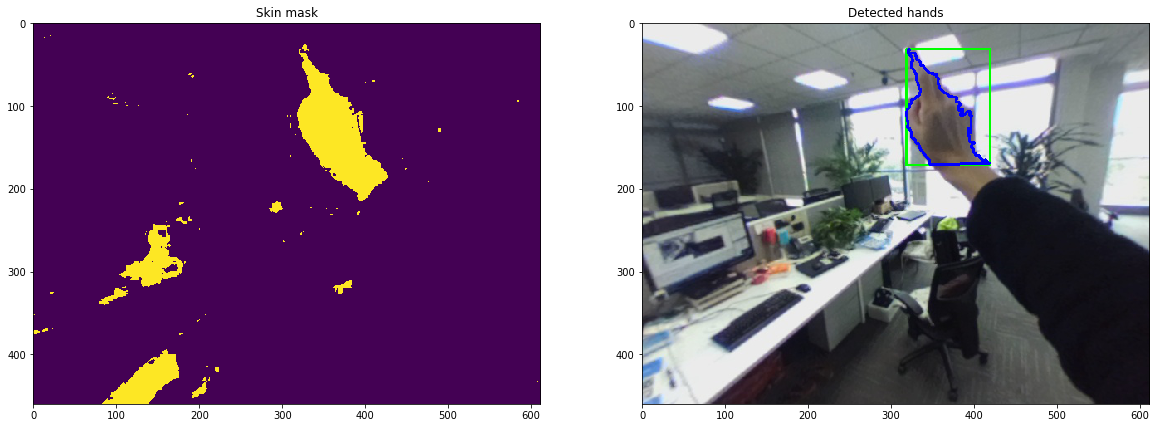

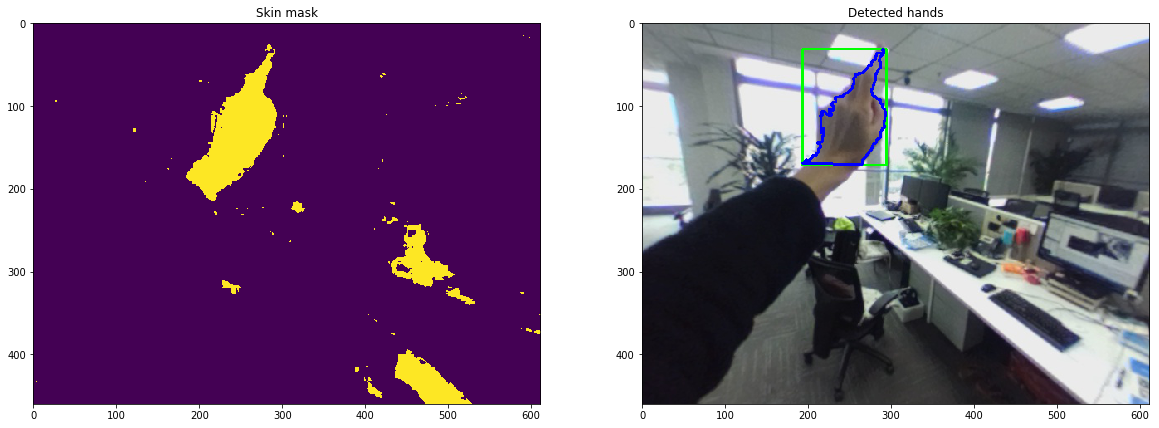

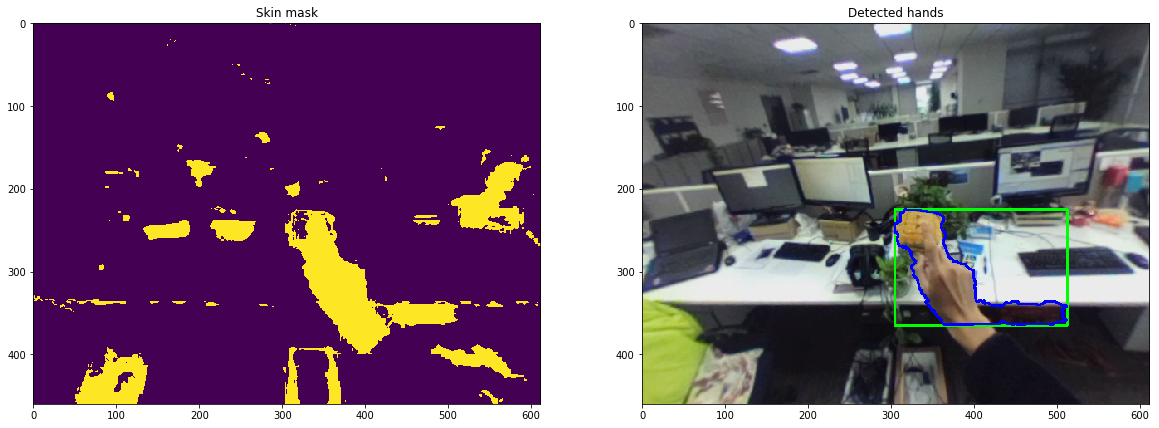

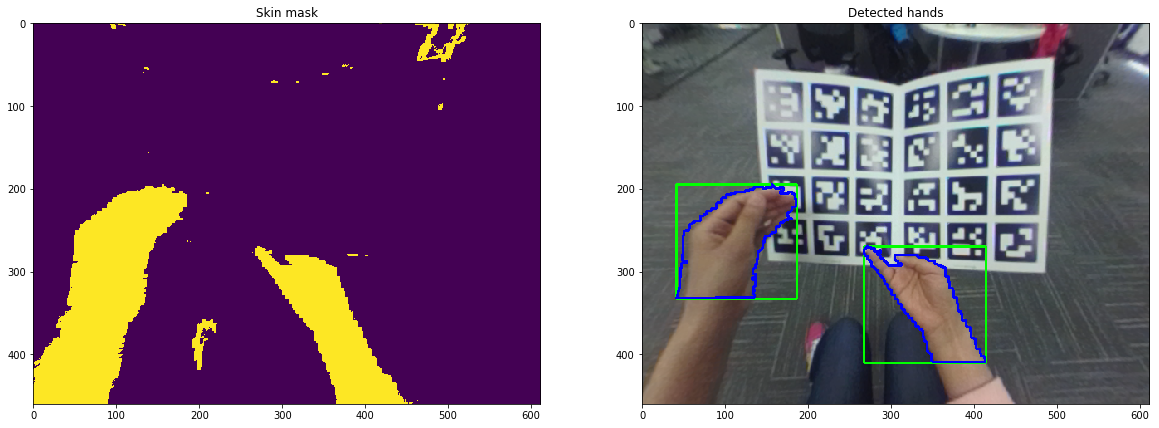

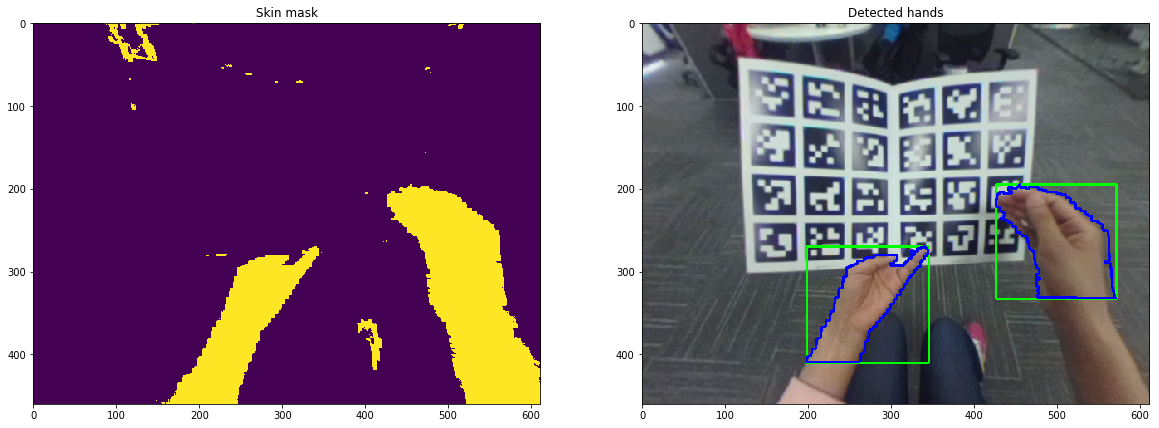

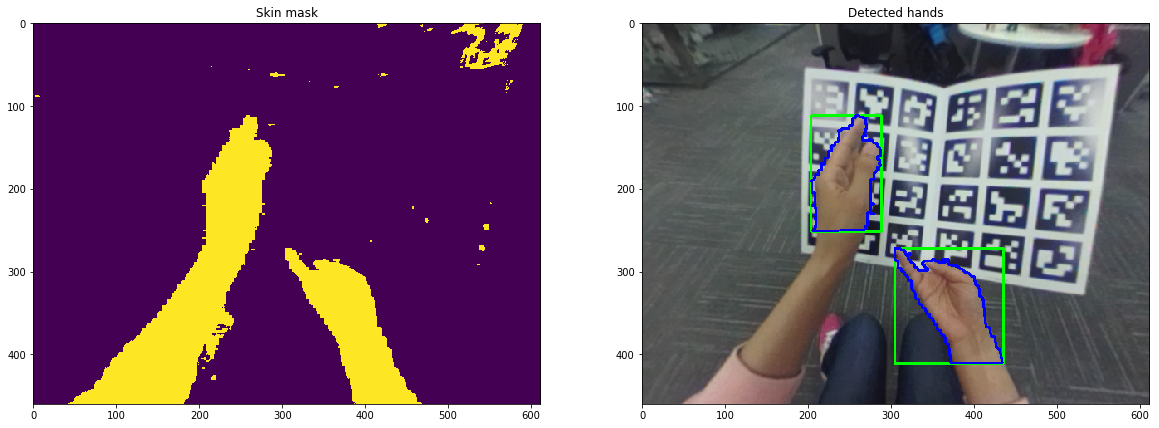

In [151]:
import judger_hand
test_files = judger_hand.get_file_names()
output_f = judger_hand.get_output_file_object()
for fname in test_files:
    img = imread(fname)
    
    bbox, img, sk = find_hand_by_color(img)
    plt.figure(figsize=(20, 20))
    plt.subplot(1,2,1)
    plt.title('Skin mask')
    plt.imshow(sk)
    plt.subplot(1,2,2)
    plt.title('Detected hands')
    plt.imshow(img)
    print(bbox)

    #/data/image1.png 200 50 300 150 0 0.9
    for hand, box in bbox['bbox'].items():
        hand = 0 if hand == 'L' else 1
        output_f.write(('%s %d %d %d %d %d 0.0 \n' % (fname, box[0], box[1], box[2], box[3], hand)).encode())
            
judger_hand.judge()

In [7]:
def IOU(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = (xB - xA + 1) * (yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

acc = 0
tot = 0
for i in range(0, len(images)):
    bbox, img_ = find_hand_by_color(images[i])
    print(labels[i])
    for hand, box in labels[i]['bbox'].items():
        tot += 1
        box_ = bbox['bbox'].get(hand)
        if box_ and IOU(box, box_) > 0.5:
            acc += 1
    bbox, _, _ = draw_bbox(img_, labels[i])
    #plt.figure(figsize=(10,10))
    #plt.imshow(bbox)
    
print(acc/tot)

[(25900, [236, 120, 185, 140]), (10270, [217, 330, 79, 130])]
{'bbox': {'R': [236, 120, 421, 260], 'L': [217, 330, 296, 460]}}
{'bbox': {'R': [219, 108, 393, 265], 'L': [218, 320, 313, 455]}}
[(21700, [370, 265, 155, 140]), (11070, [208, 325, 82, 135])]
{'bbox': {'R': [370, 265, 525, 405], 'L': [208, 325, 290, 460]}}
{'bbox': {'R': [357, 250, 513, 399], 'L': [213, 324, 296, 460]}}
[(25900, [200, 165, 185, 140]), (5346, [214, 361, 54, 99])]
{'bbox': {'R': [200, 165, 385, 305], 'L': [214, 361, 268, 460]}}
{'bbox': {'R': [185, 150, 347, 292], 'L': [218, 324, 311, 457]}}
[(7875, [201, 355, 75, 105]), (7104, [283, 386, 96, 74])]
{'bbox': {'L': [201, 355, 276, 460], 'R': [283, 386, 379, 460]}}
{'bbox': {'R': [270, 378, 448, 460], 'L': [200, 340, 277, 460]}}
[(24220, [216, 152, 173, 140]), (5488, [213, 362, 56, 98])]
{'bbox': {'R': [216, 152, 389, 292], 'L': [213, 362, 269, 460]}}
{'bbox': {'R': [194, 138, 361, 282], 'L': [218, 322, 308, 450]}}
[(17080, [362, 261, 122, 140]), (8322, [186, 346

[(25060, [395, 270, 179, 140]), (10790, [213, 330, 83, 130])]
{'bbox': {'R': [395, 270, 574, 410], 'L': [213, 330, 296, 460]}}
{'bbox': {'R': [386, 258, 569, 421], 'L': [213, 320, 314, 459]}}
[(23520, [145, 189, 168, 140]), (14560, [414, 299, 104, 140])]
{'bbox': {'L': [145, 189, 313, 329], 'R': [414, 299, 518, 439]}}
{'bbox': {'R': [372, 290, 519, 457], 'L': [164, 123, 317, 311]}}
[(20440, [150, 212, 146, 140]), (7378, [386, 275, 62, 119])]
{'bbox': {'L': [150, 212, 296, 352], 'R': [386, 275, 448, 394]}}
{'bbox': {'R': [347, 265, 446, 388], 'L': [155, 135, 296, 343]}}
[(22540, [160, 168, 161, 140]), (10780, [432, 308, 77, 140])]
{'bbox': {'L': [160, 168, 321, 308], 'R': [432, 308, 509, 448]}}
{'bbox': {'R': [374, 288, 513, 455], 'L': [152, 113, 335, 385]}}
[(25480, [154, 160, 182, 140]), (13160, [416, 307, 94, 140])]
{'bbox': {'L': [154, 160, 336, 300], 'R': [416, 307, 510, 447]}}
{'bbox': {'R': [374, 294, 509, 457], 'L': [99, 105, 350, 448]}}
[(18760, [147, 193, 134, 140]), (6844, [3

[(41020, [319, 173, 293, 140]), (18088, [0, 165, 133, 136])]
{'bbox': {'R': [319, 173, 612, 313], 'L': [0, 165, 133, 301]}}
{'bbox': {'R': [400, 171, 516, 336], 'L': [261, 292, 350, 421]}}
[(75460, [0, 202, 539, 140]), (17500, [487, 169, 125, 140])]
{'bbox': {'R': [487, 169, 612, 309]}}
{'bbox': {'R': [381, 177, 505, 350], 'L': [269, 299, 362, 428]}}
[(27440, [416, 128, 196, 140]), (27090, [158, 331, 210, 129])]
{'bbox': {'R': [158, 331, 368, 460]}}
{'bbox': {'R': [423, 204, 562, 314], 'L': [301, 330, 397, 457]}}
[(34160, [368, 174, 244, 140]), (21801, [160, 331, 169, 129])]
{'bbox': {'R': [368, 174, 612, 314], 'L': [160, 331, 329, 460]}}
{'bbox': {'R': [401, 207, 508, 363], 'L': [257, 347, 348, 460]}}
[(28980, [405, 202, 207, 140]), (23520, [166, 315, 168, 140])]
{'bbox': {'R': [405, 202, 612, 342], 'L': [166, 315, 334, 455]}}
{'bbox': {'R': [401, 214, 554, 370], 'L': [274, 319, 360, 457]}}
[(9801, [3, 167, 121, 81]), (8896, [417, 84, 64, 139])]
{'bbox': {'L': [3, 167, 124, 248], 'R':

[(14445, [350, 325, 107, 135]), (13300, [95, 248, 95, 140])]
{'bbox': {'R': [350, 325, 457, 460], 'L': [95, 248, 190, 388]}}
{'bbox': {'R': [309, 315, 441, 424], 'L': [133, 189, 243, 345]}}
[(20580, [316, 319, 147, 140]), (15260, [137, 246, 109, 140])]
{'bbox': {'R': [316, 319, 463, 459], 'L': [137, 246, 246, 386]}}
{'bbox': {'R': [310, 316, 447, 416], 'L': [180, 184, 289, 342]}}
[(15609, [318, 339, 129, 121]), (6860, [112, 201, 49, 140])]
{'bbox': {'R': [318, 339, 447, 460], 'L': [112, 201, 161, 341]}}
{'bbox': {'R': [297, 332, 438, 436], 'L': [112, 169, 196, 344]}}
[(19448, [304, 324, 143, 136]), (19118, [128, 381, 242, 79])]
{'bbox': {'R': [128, 381, 370, 460]}}
{'bbox': {'R': [303, 317, 444, 425], 'L': [137, 345, 404, 460]}}
[(21560, [298, 320, 154, 140]), (8757, [158, 180, 63, 139])]
{'bbox': {'R': [298, 320, 452, 460], 'L': [158, 180, 221, 319]}}
{'bbox': {'R': [298, 311, 431, 418], 'L': [159, 135, 238, 284]}}
[(50260, [87, 313, 359, 140])]
{'bbox': {'R': [87, 313, 446, 453]}}
{'

[(45920, [236, 73, 328, 140]), (27300, [230, 250, 195, 140])]
{'bbox': {'R': [230, 250, 425, 390]}}
{'bbox': {'R': [296, 213, 411, 382], 'L': [184, 340, 309, 441]}}
[(25480, [379, 108, 182, 140]), (25397, [0, 0, 233, 109])]
{'bbox': {'R': [379, 108, 561, 248], 'L': [0, 0, 233, 109]}}
{'bbox': {'R': [344, 188, 441, 340], 'L': [185, 340, 316, 445]}}
[(44619, [0, 0, 321, 139]), (34776, [360, 76, 252, 138])]
{'bbox': {'L': [0, 0, 321, 139], 'R': [360, 76, 612, 214]}}
{'bbox': {'R': [334, 181, 472, 334], 'L': [272, 358, 401, 445]}}
[(59920, [178, 0, 428, 140]), (25060, [0, 0, 179, 140])]
{'bbox': {'R': [178, 0, 606, 140], 'L': [0, 0, 179, 140]}}
{'bbox': {'R': [445, 215, 589, 392], 'L': [257, 347, 383, 437]}}
[(83860, [0, 0, 599, 140]), (26320, [265, 318, 188, 140])]
{'bbox': {'R': [265, 318, 453, 458]}}
{'bbox': {'R': [393, 180, 527, 331], 'L': [257, 344, 387, 440]}}
[(36984, [336, 70, 276, 134]), (26180, [263, 315, 187, 140])]
{'bbox': {'R': [263, 315, 450, 455]}}
{'bbox': {'R': [405, 230

[(17220, [137, 193, 123, 140])]
{'bbox': {'L': [137, 193, 260, 333]}}
{'bbox': {'L': [152, 161, 269, 310]}}
[(17360, [184, 203, 124, 140])]
{'bbox': {'L': [184, 203, 308, 343]}}
{'bbox': {'L': [172, 185, 319, 360]}}
[(16940, [192, 212, 121, 140])]
{'bbox': {'L': [192, 212, 313, 352]}}
{'bbox': {'L': [183, 189, 315, 360]}}
[(19740, [196, 208, 141, 140])]
{'bbox': {'L': [196, 208, 337, 348]}}
{'bbox': {'L': [182, 192, 314, 358]}}
[(17080, [222, 196, 122, 140]), (2301, [306, 273, 39, 59])]
{'bbox': {'L': [306, 273, 345, 332]}}
{'bbox': {'L': [189, 174, 354, 391]}}
[(17780, [256, 254, 127, 140])]
{'bbox': {'R': [256, 254, 383, 394]}}
{'bbox': {'L': [242, 216, 399, 418]}}
[(15260, [273, 258, 109, 140])]
{'bbox': {'R': [273, 258, 382, 398]}}
{'bbox': {'L': [257, 229, 402, 401]}}
[(15820, [274, 254, 113, 140])]
{'bbox': {'R': [274, 254, 387, 394]}}
{'bbox': {'L': [260, 226, 400, 385]}}
[(17931, [238, 277, 129, 139]), (3900, [319, 335, 50, 78])]
{'bbox': {'L': [238, 277, 367, 416], 'R': [319, 

[(4884, [399, 179, 66, 74]), (3375, [457, 0, 125, 27])]
{'bbox': {'R': [457, 0, 582, 27]}}
{'bbox': {'L': [217, 171, 288, 221]}}
[(4332, [398, 185, 57, 76])]
{'bbox': {'R': [398, 185, 455, 261]}}
{'bbox': {'L': [220, 170, 295, 227]}}
[(4864, [385, 179, 64, 76]), (3111, [189, 316, 51, 61])]
{'bbox': {'R': [385, 179, 449, 255], 'L': [189, 316, 240, 377]}}
{'bbox': {'L': [218, 173, 289, 226]}}
[(5676, [394, 175, 66, 86]), (2835, [196, 305, 45, 63])]
{'bbox': {'R': [394, 175, 460, 261], 'L': [196, 305, 241, 368]}}
{'bbox': {'L': [200, 201, 274, 253]}}
[(6688, [411, 148, 76, 88])]
{'bbox': {'R': [411, 148, 487, 236]}}
{'bbox': {'L': [212, 252, 276, 299]}}
[(12348, [155, 242, 126, 98]), (6478, [425, 148, 79, 82])]
{'bbox': {'L': [155, 242, 281, 340], 'R': [425, 148, 504, 230]}}
{'bbox': {'L': [203, 289, 266, 332]}}
[(13356, [151, 233, 126, 106]), (8924, [412, 133, 92, 97])]
{'bbox': {'L': [151, 233, 277, 339], 'R': [412, 133, 504, 230]}}
{'bbox': {'L': [196, 296, 264, 340]}}
[(15180, [138, 2

[(4998, [184, 262, 119, 42])]
{'bbox': {'L': [184, 262, 303, 304]}}
{'bbox': {'L': [188, 103, 268, 173]}}
[(27160, [138, 274, 194, 140])]
{'bbox': {'L': [138, 274, 332, 414]}}
{'bbox': {'L': [172, 112, 251, 171]}}
[(31080, [143, 261, 222, 140]), (18592, [382, 348, 166, 112])]
{'bbox': {'L': [143, 261, 365, 401], 'R': [382, 348, 548, 460]}}
{'bbox': {'L': [160, 99, 246, 169]}}
[(35420, [109, 270, 253, 140]), (19075, [365, 351, 175, 109])]
{'bbox': {'L': [109, 270, 362, 410], 'R': [365, 351, 540, 460]}}
{'bbox': {'L': [136, 91, 223, 164]}}
[(38780, [79, 289, 277, 140])]
{'bbox': {'L': [79, 289, 356, 429]}}
{'bbox': {'L': [135, 101, 223, 172]}}
[(51240, [78, 283, 366, 140])]
{'bbox': {'R': [78, 283, 444, 423]}}
{'bbox': {'L': [127, 97, 211, 168]}}
[(46760, [91, 313, 334, 140]), (9975, [479, 385, 133, 75])]
{'bbox': {'R': [479, 385, 612, 460]}}
{'bbox': {'L': [167, 114, 245, 184]}}
[(20532, [143, 373, 236, 87]), (17500, [411, 246, 125, 140])]
{'bbox': {'R': [411, 246, 536, 386]}}
{'bbox': 

In [56]:
hands = left_hands + right_hands
hands_ycbcr = [cv2.cvtColor(hand, cv2.COLOR_BGR2YCR_CB) for hand in hands]
hands_lab = [cv2.cvtColor(hand, cv2.COLOR_BGR2LAB) for hand in hands]

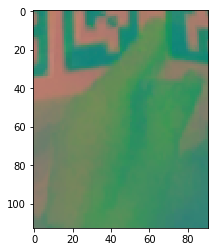

In [62]:
plt.imshow(hands_lab[100])

In [85]:
img = hands_lab[100].reshape((-1, 3))
print(np.min(img, axis=0))
print(np.max(img, axis=0))

[ 12 117  81]
[193 152 123]


In [241]:
import numpy, logging

logger = logging.getLogger('main')


def get_hsv_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting hsv mask')

    lower_thresh = numpy.array([0, 50, 0], dtype=numpy.uint8)
    upper_thresh = numpy.array([120, 150, 255], dtype=numpy.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    msk_hsv = cv2.inRange(img_hsv, lower_thresh, upper_thresh)

    msk_hsv[msk_hsv < 128] = 0
    msk_hsv[msk_hsv >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_hsv', msk_hsv)

    return msk_hsv.astype(float)


def get_rgb_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting rgb mask')

    lower_thresh = numpy.array([45, 52, 108], dtype=numpy.uint8)
    upper_thresh = numpy.array([255, 255, 255], dtype=numpy.uint8)

    mask_a = cv2.inRange(img, lower_thresh, upper_thresh)
    mask_b = 255 * ((img[:, :, 2] - img[:, :, 1]) / 20)
    mask_c = 255 * ((numpy.max(img, axis=2) - numpy.min(img, axis=2)) / 20)
    # msk_rgb = cv2.bitwise_and(mask_c, cv2.bitwise_and(mask_a, mask_b))
    mask_d = numpy.bitwise_and(numpy.uint64(mask_a), numpy.uint64(mask_b))
    msk_rgb = numpy.bitwise_and(numpy.uint64(mask_c), numpy.uint64(mask_d))

    msk_rgb[msk_rgb < 128] = 0
    msk_rgb[msk_rgb >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_rgb', msk_rgb)

    return msk_rgb.astype(float)


def get_ycrcb_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting ycrcb mask')

    lower_thresh = numpy.array([90, 100, 130], dtype=numpy.uint8)
    upper_thresh = numpy.array([230, 120, 180], dtype=numpy.uint8)

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    msk_ycrcb = cv2.inRange(img_ycrcb, lower_thresh, upper_thresh)

    msk_ycrcb[msk_ycrcb < 128] = 0
    msk_ycrcb[msk_ycrcb >= 128] = 1

    if debug:
        scripts.display('input', img)
        scripts.display('mask_ycrcb', msk_ycrcb)

    return msk_ycrcb.astype(float)


def grab_cut_mask(img_col, mask, debug=False):
    assert isinstance(img_col, numpy.ndarray), 'image must be a numpy array'
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert img_col.ndim == 3, 'skin detection can only work on color images'
    assert mask.ndim == 2, 'mask must be 2D'

    kernel = numpy.ones((50, 50), numpy.float32) / (50 * 50)
    dst = cv2.filter2D(mask, -1, kernel)
    dst[dst != 0] = 255
    free = numpy.array(cv2.bitwise_not(dst), dtype=numpy.uint8)

    if debug:
        scripts.display('not skin', free)
        scripts.display('grabcut input', mask)

    grab_mask = numpy.zeros(mask.shape, dtype=numpy.uint8)
    grab_mask[:, :] = 2
    grab_mask[mask == 255] = 1
    grab_mask[free == 255] = 0

    if numpy.unique(grab_mask).tolist() == [0, 1]:
        logger.debug('conducting grabcut')
        bgdModel = numpy.zeros((1, 65), numpy.float64)
        fgdModel = numpy.zeros((1, 65), numpy.float64)

        if img_col.size != 0:
            mask, bgdModel, fgdModel = cv2.grabCut(img_col, grab_mask, None, bgdModel, fgdModel, 5,
                                                   cv2.GC_INIT_WITH_MASK)
            mask = numpy.where((mask == 2) | (mask == 0), 0, 1).astype(numpy.uint8)
        else:
            logger.warning('img_col is empty')

    return mask


def closing(mask):
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert mask.ndim == 2, 'mask must be a greyscale image'
    logger.debug("closing mask of shape {0}".format(mask.shape))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    return mask


def process(img, thresh=0.5, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug("processing image of shape {0}".format(img.shape))

    mask_hsv = get_hsv_mask(img, debug=debug)
    mask_rgb = get_rgb_mask(img, debug=debug)
    mask_ycrcb = get_ycrcb_mask(img, debug=debug)

    n_masks = 3.0
    mask = (mask_hsv + mask_rgb + mask_ycrcb) / n_masks

    mask[mask < thresh] = 0.0
    mask[mask >= thresh] = 255.0
    logger.debug('{0}% of the image is skin'.format(int((100.0 / 255.0) * numpy.sum(mask) / mask.size)))

    mask = mask.astype(numpy.uint8)

    mask = closing(mask)
    mask = grab_cut_mask(img, mask, debug=debug)

    return mask

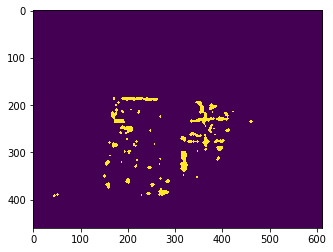

In [249]:
plt.imshow(process(images[100], 0.35))

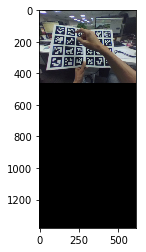

In [103]:
import numpy as np
import cv2 as cv
roi = hands[100][40:60, 20:40]
hsv = cv.cvtColor(roi,cv.COLOR_BGR2HSV)
target = images[0]
hsvt = cv.cvtColor(target,cv.COLOR_BGR2HSV)
# calculating object histogram
roihist = cv.calcHist([hsv],[0, 1], None, [180, 256], [0, hsv.shape[0], 0, hsv.shape[1]] )
# normalize histogram and apply backprojection
cv.normalize(roihist,roihist,0,255,cv.NORM_MINMAX)
dst = cv.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)
# Now convolute with circular disc
disc = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
cv.filter2D(dst,-1,disc,dst)
# threshold and binary AND
ret,thresh = cv.threshold(dst,50,255,0)
thresh = cv.merge((thresh,thresh,thresh))
res = cv.bitwise_and(target,thresh)
res = np.vstack((target,thresh,res))
plt.imshow(res)

(180, 256)